# Imputation

While some models (e.g. XGBoost) can cope with missing data by default, some models will require us to deal with missing values ourselves, and it can be valuable to deal with missing values using our own chosen methods even when the model can cope with the missing values as its methods can often be simplistic.

In [196]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

Let's load in the new packages for this notebook.

In [197]:
from sklearn.impute import SimpleImputer
# sklearn iterative imputer is still experimental so needs a special import
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

Let's load in and split our dataset.

The processed titanic dataset has already dealt with missing data, so we're going to go back to the unprocessed dataset.

Therefore, we're also going to undertake some of the steps from the `data_preprocessing_and_eda.ipynb` file.

In [198]:
try:
    data = pd.read_csv("data/raw_data.csv")

except FileNotFoundError:

    # Download raw data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/train.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'raw_data.csv', index=False)

print(f"Total number of rows in raw dataset: {len(data)}")


Total number of rows in raw dataset: 891


## Some initial preprocessing of the raw data prior to imputation

Let's take a look at a sample of the data.

In [199]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's look at some of the column counts, passing in `dropna=False` to ensure any missing values (if any) are included in counts.

In [200]:
data['SibSp'].value_counts(dropna=False)

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

We can also get a summary of missing values.

In [201]:
pd.DataFrame(
    data.isna().mean().round(4),
    columns=["Percentage of Values Missing"]
    )

,Percentage of Values Missing
PassengerId,0.0000
Survived,0.0000
Pclass,0.0000
Name,0.0000
Sex,0.0000
Age,0.1987
SibSp,0.0000
Parch,0.0000
Ticket,0.0000
Fare,0.0000


Let's do a couple of preprocessing steps.

In [202]:
###############################
# Replace unclear data values #
###############################
embarked_lookup = {
    'S': 'Southampton',
    'C':  'Cherbourg',
    'Q': 'Queenstown'
}

# Note that 'get' defaults to 'None' if the key doesn't appear in the dictionary lookup.
data['Embarked'] = data['Embarked'].apply(lambda row_value: embarked_lookup.get(row_value))

data['Embarked'].value_counts(dropna=False)

Southampton    644
Cherbourg      168
Queenstown      77
None             2
Name: Embarked, dtype: int64

In [203]:
#######################
# One hot encoding    #
#######################
# here we've asked for an additional column when no value is recorded for the embarkation point
one_hot = pd.get_dummies(data['Embarked'], prefix='Embarked', dummy_na=True).astype('int')
# Drop the column as it is now encoded
data = data.drop('Embarked', axis = 1)
# Join the encoded df
data = data.join(one_hot, how="left")


We can now just confirm that the number of people missing agree with our dataset from before.

In [204]:
data.loc[:, data.columns.str.startswith('Embarked')].sum(axis=0)

Embarked_Cherbourg      168
Embarked_Queenstown      77
Embarked_Southampton    644
Embarked_nan              2
dtype: int64

Now let's deal with our remaining preprocessing steps.

Notice that here we don't do anything to values that are neither male nor female so they will remain as their original value.

From our initial checks, we know that in this case no values were missing in the `Sex` column anyway.

In [205]:
#######################
# Dichotomous columns #
#######################
data['Sex'].replace('male', 1, inplace=True)
data['Sex'].replace('female', 0, inplace=True)
data = data.rename(columns={'Sex': 'IsMale'})

Now let's tidy up and display our final output.

In [206]:
#####################################
# Tidying up remaining column names #
#####################################
data = data.drop(columns=['Name', 'Ticket', 'Cabin'])
data = data.rename(columns={'Embarked_nan':'Embarked_Unknown'})

data.head()

,PassengerId,Survived,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Embarked_Unknown
0,1,0,3,1,22.0,1,0,7.2500,0,0,1,0
1,2,1,1,0,38.0,1,0,71.2833,1,0,0,0
2,3,1,3,0,26.0,0,0,7.9250,0,0,1,0
3,4,1,1,0,35.0,1,0,53.1000,0,0,1,0
4,5,0,3,1,35.0,0,0,8.0500,0,0,1,0


Now let's get our data ready for machine learning. 

In [207]:
data = data.astype(float)

# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

feature_names = X.columns.tolist()

Finally, let's check we haven't lost or gained any rows!

(if we were automating this, we may turn this into a hard-coded test that will cause the notebook/script to fail if the dataset is no longer the same size as the original dataset).

In [208]:
print(f"Total number of rows in raw dataset: {len(data)}")

Total number of rows in raw dataset: 891


## Checking for Missing Values

Let's just remind ourselves of our columns and their missing data.

In [209]:
pd.DataFrame(
    (data.isna().mean()*100).round(2),
    columns=["Percentage of Values Missing"]
    )

,Percentage of Values Missing
Survived,0.00
Pclass,0.00
IsMale,0.00
Age,19.87
SibSp,0.00
Parch,0.00
Fare,0.00
Embarked_Cherbourg,0.00
Embarked_Queenstown,0.00
Embarked_Southampton,0.00


We could choose to impute the embarkation as well; however, in this case, as it's a low number of samples we will just choose to stick with that being unknown.  

## A note on the order of steps

To avoid *leakage* - where information from the testing data, like the distribution of data, influences your training data - you should perform imputation steps *after* splitting your data into training and testing datasets.

In [210]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training Dataset Samples: {len(X_train)}")
print(f"Validation Dataset Samples: {len(X_validate)}")
print(f"Testing Dataset Samples: {len(X_test)}")

Training Dataset Samples: 569
Validation Dataset Samples: 143
Testing Dataset Samples: 179


This is why imputing categorical columns can complicate things slightly - you need to do the split, but then you will need to apply some transformations - like one-hot encoding - to each dataset separately.

Good use of functions can ensure this is a relatively painless process - but is not one we'll cover today. 

## Exploring the distribution prior to imputation

As we're just looking at age today, let's take a look at that column and some statistics.

In [211]:
X_train['Age'].mean()

28.99313043478261

In [212]:
X_train['Age'].median()

28.0

In [213]:
X_train['Age'].mode()

0    24.0
Name: Age, dtype: float64

<Axes: >

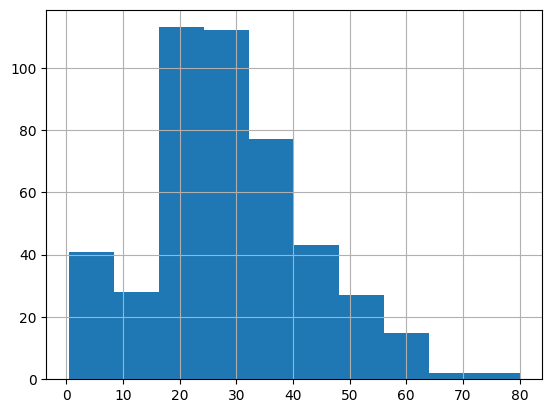

In [214]:
X_train['Age'].hist()

Let's find the missing values and pull them out so we can track how they change.

In [215]:
indices_missing_age = X_train[X_train['Age'].isna()].index
indices_missing_age

Int64Index([517, 792, 420,  95, 495, 384, 159, 301, 826, 274,
            ...
            468, 470,  64, 223, 564, 284, 888,  19, 295, 214],
           dtype='int64', length=109)

## Simple Imputation

### Mean Imputation

First, we'll just show how to replace every missing value in 'Age' with the mean value for age using the SimpleImputer.

In [216]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_mean_imp = imp_mean.fit_transform(X_train)

X_train_mean_imp

array([[ 3.        ,  1.        , 28.99313043, ...,  1.        ,
         0.        ,  0.        ],
       [ 3.        ,  0.        , 28.99313043, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.        ,  0.        , 33.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 2.        ,  1.        , 29.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 3.        ,  0.        , 27.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 3.        ,  1.        , 20.        , ...,  0.        ,
         1.        ,  0.        ]])

However, when we do this, we find that our output is now a numpy array instead of a dataframe. 

We can use the following notation to avoid this issue.

In [217]:
X_train_mean_imp = X_train.copy()
X_train_mean_imp.values[:] = SimpleImputer().fit_transform(X_train)
X_train_mean_imp

,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Embarked_Unknown
517,3.0,1.0,28.99313,0.0,0.0,24.1500,0.0,1.0,0.0,0.0
792,3.0,0.0,28.99313,8.0,2.0,69.5500,0.0,0.0,1.0,0.0
472,2.0,0.0,33.00000,1.0,2.0,27.7500,0.0,0.0,1.0,0.0
483,3.0,0.0,63.00000,0.0,0.0,9.5875,0.0,0.0,1.0,0.0
9,2.0,0.0,14.00000,1.0,0.0,30.0708,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
79,3.0,0.0,30.00000,0.0,0.0,12.4750,0.0,0.0,1.0,0.0
164,3.0,1.0,1.00000,4.0,1.0,39.6875,0.0,0.0,1.0,0.0
117,2.0,1.0,29.00000,1.0,0.0,21.0000,0.0,0.0,1.0,0.0
8,3.0,0.0,27.00000,0.0,2.0,11.1333,0.0,0.0,1.0,0.0


Let's see what this has done to our data distribution.

<Axes: >

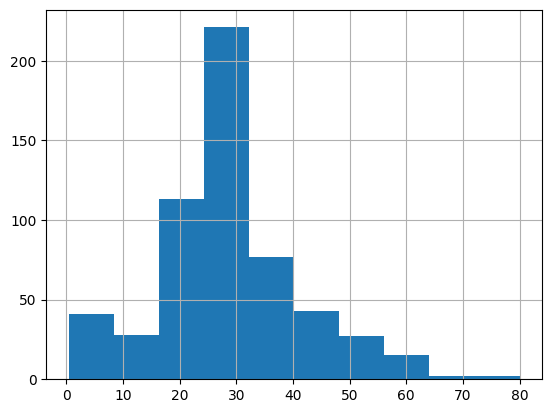

In [218]:
X_train_mean_imp['Age'].hist()

This looks quite different to our original distribution.

<Axes: >

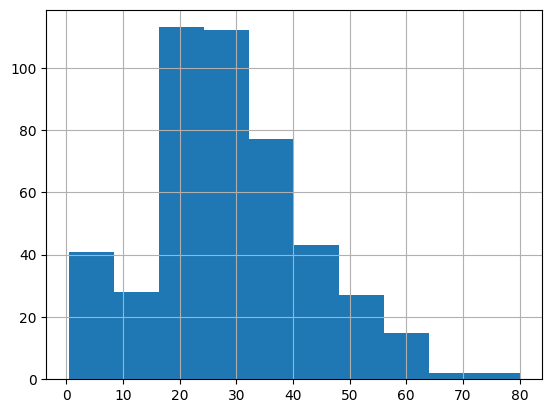

In [219]:
X_train['Age'].hist()

Let's look at the individual rows.

In [220]:
X_train_mean_imp.loc[indices_missing_age]

,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Embarked_Unknown
517,3.0,1.0,28.99313,0.0,0.0,24.1500,0.0,1.0,0.0,0.0
792,3.0,0.0,28.99313,8.0,2.0,69.5500,0.0,0.0,1.0,0.0
420,3.0,1.0,28.99313,0.0,0.0,7.8958,1.0,0.0,0.0,0.0
95,3.0,1.0,28.99313,0.0,0.0,8.0500,0.0,0.0,1.0,0.0
495,3.0,1.0,28.99313,0.0,0.0,14.4583,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
284,1.0,1.0,28.99313,0.0,0.0,26.0000,0.0,0.0,1.0,0.0
888,3.0,0.0,28.99313,1.0,2.0,23.4500,0.0,0.0,1.0,0.0
19,3.0,0.0,28.99313,0.0,0.0,7.2250,1.0,0.0,0.0,0.0
295,1.0,1.0,28.99313,0.0,0.0,27.7208,1.0,0.0,0.0,0.0


We can see that they all have the same value!

In [221]:
X_train_mean_imp.loc[indices_missing_age]['Age'].value_counts()

28.99313    109
Name: Age, dtype: int64

We should round this to the nearest integer to match the original data.

In [222]:
X_train_mean_imp['Age'] = X_train_mean_imp['Age'].round(0)
X_train_mean_imp.head()

,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Embarked_Unknown
517,3.0,1.0,29.0,0.0,0.0,24.1500,0.0,1.0,0.0,0.0
792,3.0,0.0,29.0,8.0,2.0,69.5500,0.0,0.0,1.0,0.0
472,2.0,0.0,33.0,1.0,2.0,27.7500,0.0,0.0,1.0,0.0
483,3.0,0.0,63.0,0.0,0.0,9.5875,0.0,0.0,1.0,0.0
9,2.0,0.0,14.0,1.0,0.0,30.0708,1.0,0.0,0.0,0.0


### Function: Simple Imputation

We could turn this into a function to make it quicker to carry out.

In [223]:
def impute_missing_df(df, impute_type="mean"):
    imputed_df = df.copy()
    imputed_df.values[:] = SimpleImputer(missing_values=np.nan, strategy=impute_type).fit_transform(df)
    return imputed_df

### Mode

Let's now impute using the modal (most common) value.

In [224]:
X_train_mode_imp = impute_missing_df(X_train, impute_type="most_frequent")

In [225]:
X_train_mode_imp.loc[indices_missing_age].head()

,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Embarked_Unknown
517,3.0,1.0,24.0,0.0,0.0,24.1500,0.0,1.0,0.0,0.0
792,3.0,0.0,24.0,8.0,2.0,69.5500,0.0,0.0,1.0,0.0
420,3.0,1.0,24.0,0.0,0.0,7.8958,1.0,0.0,0.0,0.0
95,3.0,1.0,24.0,0.0,0.0,8.0500,0.0,0.0,1.0,0.0
495,3.0,1.0,24.0,0.0,0.0,14.4583,1.0,0.0,0.0,0.0


### Median

In [226]:
X_train_median_imp = impute_missing_df(X_train, impute_type="median")
X_train_median_imp.loc[indices_missing_age].head()

,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Embarked_Unknown
517,3.0,1.0,28.0,0.0,0.0,24.1500,0.0,1.0,0.0,0.0
792,3.0,0.0,28.0,8.0,2.0,69.5500,0.0,0.0,1.0,0.0
420,3.0,1.0,28.0,0.0,0.0,7.8958,1.0,0.0,0.0,0.0
95,3.0,1.0,28.0,0.0,0.0,8.0500,0.0,0.0,1.0,0.0
495,3.0,1.0,28.0,0.0,0.0,14.4583,1.0,0.0,0.0,0.0


## Iterative Imputation

In the documentation, IterativeImputer is described as a "Multivariate imputer that estimates each feature from all the others.

A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion."

Let's go straight to writing a function for this to make it easier to apply. 

`**kwargs` is a special parameter in python. Here, we're just using it to pass any number of arguments directly through to the IterativeImputer function so we don't have to explicitly specify all of the different arguments we might want to allow someone to pass through to the IterativeImputer.

In [227]:
def impute_missing_df_iterative(df, **kwargs):
    imputed_df = df.copy()
    imputed_df.values[:] = IterativeImputer(**kwargs).fit_transform(df)
    return imputed_df

In [228]:
X_train_iterative_imp = impute_missing_df_iterative(
    X_train,
    missing_values=np.nan,
    random_state=42
    )
X_train_iterative_imp.loc[indices_missing_age].head()

,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Embarked_Unknown
517,3.0,1.0,26.458273,0.0,0.0,24.1500,0.0,1.0,0.0,0.0
792,3.0,0.0,-4.786686,8.0,2.0,69.5500,0.0,0.0,1.0,0.0
420,3.0,1.0,26.157474,0.0,0.0,7.8958,1.0,0.0,0.0,0.0
95,3.0,1.0,27.785451,0.0,0.0,8.0500,0.0,0.0,1.0,0.0
495,3.0,1.0,26.065750,0.0,0.0,14.4583,1.0,0.0,0.0,0.0


Straight away we can see a slight problem - someone with an age of minus 4!

We can fix that by passing in the `IterativeImputer` argument `min_value`. 

In [229]:
X_train_iterative_imp = impute_missing_df_iterative(
    X_train,
    min_value=0,
    missing_values=np.nan,
    random_state=42
    )

X_train_iterative_imp.head()

,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Embarked_Unknown
517,3.0,1.0,26.458273,0.0,0.0,24.1500,0.0,1.0,0.0,0.0
792,3.0,0.0,0.000000,8.0,2.0,69.5500,0.0,0.0,1.0,0.0
472,2.0,0.0,33.000000,1.0,2.0,27.7500,0.0,0.0,1.0,0.0
483,3.0,0.0,63.000000,0.0,0.0,9.5875,0.0,0.0,1.0,0.0
9,2.0,0.0,14.000000,1.0,0.0,30.0708,1.0,0.0,0.0,0.0


Let's just look at the values for those rows that previously had missing values in 'age'.

In [230]:
X_train_iterative_imp.loc[indices_missing_age].head()

,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Embarked_Unknown
517,3.0,1.0,26.458273,0.0,0.0,24.1500,0.0,1.0,0.0,0.0
792,3.0,0.0,0.000000,8.0,2.0,69.5500,0.0,0.0,1.0,0.0
420,3.0,1.0,26.157474,0.0,0.0,7.8958,1.0,0.0,0.0,0.0
95,3.0,1.0,27.785451,0.0,0.0,8.0500,0.0,0.0,1.0,0.0
495,3.0,1.0,26.065750,0.0,0.0,14.4583,1.0,0.0,0.0,0.0


Let's compare this new dataframe with the original.

Text(0.5, 1.0, 'Iterative Imputation')

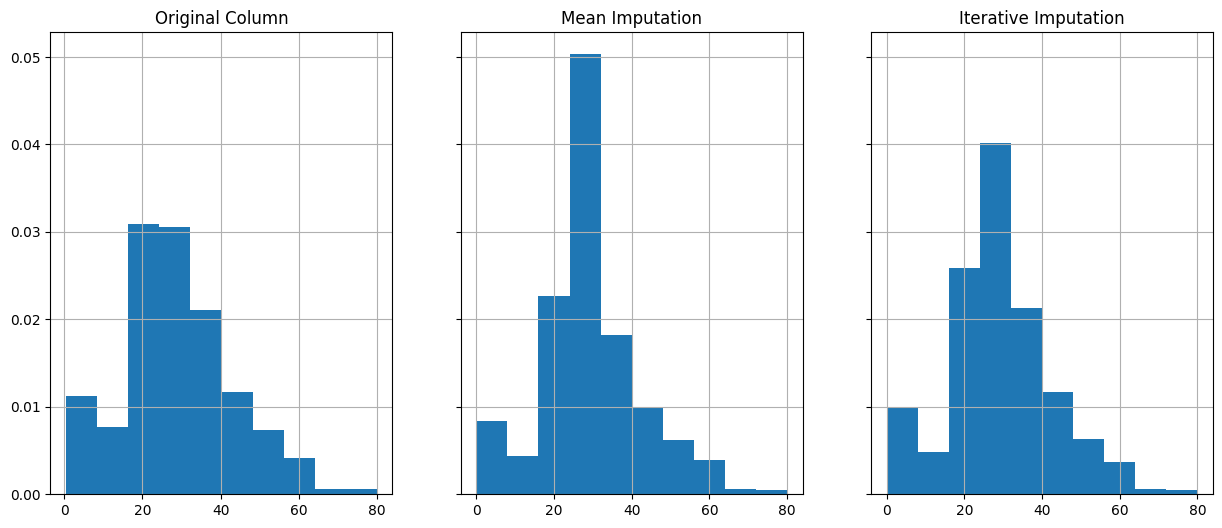

In [231]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
X_train['Age'].hist(ax=ax1, density=True)
X_train_mean_imp['Age'].hist(ax=ax2, density=True)
X_train_iterative_imp['Age'].hist(ax=ax3, density=True)
ax1.set_title('Original Column')
ax2.set_title('Mean Imputation')
ax3.set_title('Iterative Imputation')

Let's overlay the original data distribution to compare the approaches. 

Text(0.5, 1.0, 'Iterative Imputation')

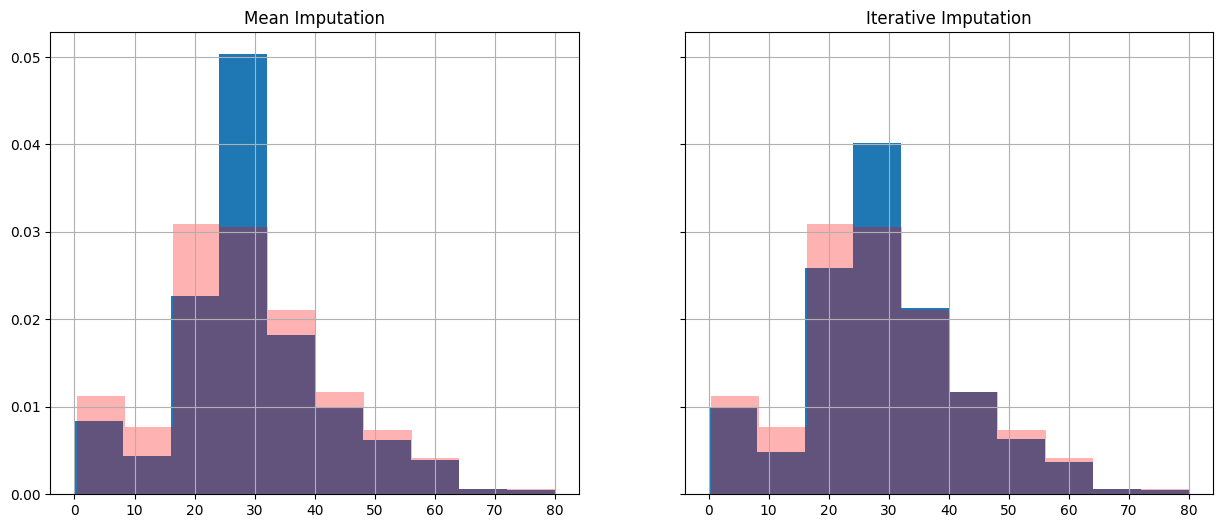

In [232]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
X_train_mean_imp['Age'].hist(ax=ax1, density=True)
X_train_iterative_imp['Age'].hist(ax=ax2, density=True)
X_train['Age'].hist(ax=ax1, alpha=0.3, color="red", density=True)
X_train['Age'].hist(ax=ax2, alpha=0.3, color="red", density=True)
ax1.set_title('Mean Imputation')
ax2.set_title('Iterative Imputation')

# Next Steps

Remember we split out our training and testing data - so we would need to repeat this process on our validation and testing datasets.

Sklearn pipelines can make it easier to apply the imputation steps and avoid data leakage. 